In [1]:
import random
from collections import namedtuple
import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
random.seed()

In [4]:
def Rand_num():
    x=[random.random(),
    random.random(),
    random.random(),
    random.random(),
    random.random(),
    random.random(),
    random.random(),
    random.random(),
    random.random(),
    random.random(),
    random.random()]
    return x
    

In [5]:
#! /usr/bin/env python

# Summary:
#   An implementation of the Chou-Fasman algorithm
# Authors:
#   Samuel A. Rebelsky (layout of the program see:
#   http://www.cs.grinnell.edu/~rebelsky/ExBioPy/Projects/project-7.5.html)
#   Nicolas Girault


import string
import sys


#protein1 = 'MKIDAIVGRNSAKDIRTEERARVQLGNVVTAAALHGGIRISDQTTNSVETVVGKGESRVLIGNEYGGKGFWDNHHHHHH'
#protein2 = 'MRRYEVNIVLNPNLDQSQLALEKEIIQRALENYGARVEKVAILGLRRLAYPIAKDPQGYFLWYQVEMPEDRVNDLARELRIRDNVRRVMVVKSQEPFLANA'
#protein3 = 'MVGLTTLFWLGAIGMLVGTLAFAWAGRDAGSGERRYYVTLVGISGIAAVAYVVMALGVGWVPVAERTVFAPRYIDWILTTPLIVYFLGLLAGLDSREFGIVITLNTVVMLAGFAGAMVPGIERYALFGMGAVAFLGLVYYLVGPMTESASQRSSGIKSLYVRLRNLTVILWAIYPFIWLLGPPGVALLTPTVDVALIVYLDLVTKVGFGFIALDAAATLRAEHGESLAGVDTDAPAVAD'

# The Chou-Fasman table, with rows of the table indexed by amino acid name.
#   Data copied, pasted, and reformatted from 
#     http://prowl.rockefeller.edu/aainfo/chou.htm
# Columns are          SYM,P(a), P(b),P(turn), f(i),   f(i+1), f(i+2), f(i+3)

CF = {}
CF['Alanine']       = ['A', 142,   83,   66,   0.06,   0.076,  0.035,  0.058]
CF['Arginine']      = ['R',  98,   93,   95,   0.070,  0.106,  0.099,  0.085]
CF['Aspartic Acid'] = ['N', 101,   54,  146,   0.147,  0.110,  0.179,  0.081]
CF['Asparagine']    = ['D',  67,   89,  156,   0.161,  0.083,  0.191,  0.091]
CF['Cysteine']      = ['C',  70,  119,  119,   0.149,  0.050,  0.117,  0.128]
CF['Glutamic Acid'] = ['E', 151,   37,   74,   0.056,  0.060,  0.077,  0.064]
CF['Glutamine']     = ['Q', 111,  110,   98,   0.074,  0.098,  0.037,  0.098]
CF['Glycine']       = ['G',  57,   75,  156,   0.102,  0.085,  0.190,  0.152]
CF['Histidine']     = ['H', 100,   87,   95,   0.140,  0.047,  0.093,  0.054]
CF['Isoleucine']    = ['I', 108,  160,   47,   0.043,  0.034,  0.013,  0.056]
CF['Leucine']       = ['L', 121,  130,   59,   0.061,  0.025,  0.036,  0.070]
CF['Lysine']        = ['K', 114,   74,  101,   0.055,  0.115,  0.072,  0.095]
CF['Methionine']    = ['M', 145,  105,   60,   0.068,  0.082,  0.014,  0.055]
CF['Phenylalanine'] = ['F', 113,  138,   60,   0.059,  0.041,  0.065,  0.065]
CF['Proline']       = ['P',  57,   55,  152,   0.102,  0.301,  0.034,  0.068]
CF['Serine']        = ['S',  77,   75,  143,   0.120,  0.139,  0.125,  0.106]
CF['Threonine']     = ['T',  83,  119,   96,   0.086,  0.108,  0.065,  0.079]
CF['Tryptophan']    = ['W', 108,  137,   96,   0.077,  0.013,  0.064,  0.167]
CF['Tyrosine']      = ['Y',  69,  147,  114,   0.082,  0.065,  0.114,  0.125]
CF['Valine']        = ['V', 106,  170,   50,   0.062,  0.048,  0.028,  0.053]
CF['-']             = ['-', 0  ,  0  ,  0  ,   0    ,  0    ,  0    ,  0    ]
aa_names = ['Alanine', 'Arginine', 'Asparagine', 'Aspartic Acid',
            'Cysteine', 'Glutamic Acid', 'Glutamine', 'Glycine',
            'Histidine', 'Isoleucine', 'Leucine', 'Lysine',
            'Methionine', 'Phenylalanine', 'Proline', 'Serine',
            'Threonine', 'Tryptophan', 'Tyrosine', 'Valine','-']

Pa = { }
Pb = { }
Pturn = { }
F0 = { }
F1 = { }
F2 = { }
F3 = { }

# Convert the Chou-Fasman table above to more convenient formats
#    Note that for any amino acid, aa CF[aa][0] gives the abbreviation
#    of the amino acid.
for aa in aa_names:
    Pa[CF[aa][0]] = CF[aa][1]
    Pb[CF[aa][0]] = CF[aa][2]
    Pturn[CF[aa][0]] = CF[aa][3]
    F0[CF[aa][0]] = CF[aa][4]
    F1[CF[aa][0]] = CF[aa][5]
    F2[CF[aa][0]] = CF[aa][6]
    F3[CF[aa][0]] = CF[aa][7]


def CF_find_alpha(seq):
    """Find all likely alpha helices in sequence.  Returns a list
       of [start,end] pairs for the alpha helices."""
    start = 0
    results = []
    # Try each window
    while (start + 6 < len(seq)):
        # Count the number of "good" amino acids (those likely to be
        # in an alpha helix).
        numgood = 0
        for i in range(start, start+6):
            if (Pa[seq[i]] > 100):
                numgood = numgood + 1
        if (numgood >= 4):
            [estart,end] = CF_extend_alpha(seq, start, start+6)
            #print "Exploring potential alpha " + str(estart) + ":" + str(end)
            #if (CF_good_alpha(seq[estart:end])):
            if [estart,end] not in results:
                results.append([estart,end])
        # Go on to the next frame
        start = start + 1
    # That's it, we're done
    return results

def CF_extend_alpha(seq, start, end):
    """Extend a potential alpha helix sequence.  Return the endpoints
       of the extended sequence.
    """
    # We extend the region in both directions until the average propensity for a set of four 
    # contiguous residues has Pa( ) < 100, which means we assume the helix ends there

    # seq[end-3:end+1] is: x | x | x | END
    while ( float(sum([Pa[x] for x in seq[end-3:end+1]])) / float(4) ) > 100 and end < len(seq)-1:
        end += 1
    # seq[start:start+4] is: START | x | x | x
    while ( float(sum([Pa[x] for x in seq[start:start+4]])) / float(4) ) > 100 and start > 0:
        start -= 1

    return [start,end]

#def CF_good_alpha(subseq):
#    """Determine if a subsequence appears to be an alpha helix."""
#    sum_Pa = 0
#    for aa in subseq:
#        sum_Pa = sum_Pa + Pa[aa]
#    ave_Pa = sum_Pa/len(subseq)
#    # Criteria need to be extended
#    return (ave_Pa > 100)

def CF_find_beta(seq):
    """Find all likely beta strands in seq.  Returns a list
       of [start,end] pairs for the beta strands."""
    start = 0
    results = []
    # Try each window
    while (start + 5 < len(seq)):
        # Count the number of "good" amino acids (those likely to be
        # in an beta sheet).
        numgood = 0
        for i in range(start, start+5):
            if (Pb[seq[i]] > 100):
                numgood = numgood + 1
        if (numgood >= 3):
            [estart,end] = CF_extend_beta(seq, start, start+5)
            #print "Exploring potential alpha " + str(estart) + ":" + str(end)
            #if (CF_good_alpha(seq[estart:end])):
            if [estart,end] not in results:
                results.append([estart,end])
        # Go on to the next frame
        start = start + 1
    # That's it, we're done
    return results

def CF_extend_beta(seq, start, end):
    """Extend a potential beta helix sequence.  Return the endpoints
       of the extended sequence.
    """
    # We extend the region in both directions until the average propensity for a set of four 
    # contiguous residues has Pa( ) < 100, which means we assume the helix ends there

    # seq[end-3:end+1] is: x | x | x | END
    while ( float(sum([Pb[x] for x in seq[end-3:end+1]])) / float(4) ) > 100 and end < len(seq)-1:
        end += 1
    # seq[start:start+4] is: START | x | x | x
    while ( float(sum([Pb[x] for x in seq[start:start+4]])) / float(4) ) > 100 and start > 0:
        start -= 1
    return [start,end]


def CF_find_turns(seq):
    """Find all likely beta turns in seq.  Returns a list of positions
       which are likely to be turns."""
    result = []
    for i in range(len(seq)-3):
    # CONDITION 1
        c1 = F0[seq[i]]*F1[seq[i+1]]*F2[seq[i+2]]*F3[seq[i+3]] > 0.000075
    # CONDITION 2
        c2 = ( float(sum([Pturn[x] for x in seq[i:i+4]])) / float(4) ) > 100
    # CONDITION 3
        c3 = sum([Pturn[x] for x in seq[i:i+4]]) > max(sum([Pa[x] for x in seq[i:i+4]]),sum([Pb[x] for x in seq[i:i+4]]))
        if c1 and c2 and c3:
            result.append(i)
    return result

def region_overlap(region_a, region_b):
    """Given two regions, represented as two-element lists, determine
       if the two regions overlap.
    """
    return (region_a[0] <= region_b[0] <= region_a[1]) or \
           (region_b[0] <= region_a[0] <= region_b[1])
          
def region_merge(region_a, region_b):
    """Given two regions, represented as two-element lists, return
       the minimum region that contains both regions.
    """
    return [min(region_a[0], region_b[0]), max(region_a[1], region_b[1])]

def region_intersect(region_a, region_b):
    """Given two regions, represented as two-element lists, return
       the intersection of the two regions.
    """
    return [max(region_a[0], region_b[0]), min(region_a[1], region_b[1])]

def region_difference(region_a, region_b):
    """Given two regions, represented as two-element lists, return
       the part of region_a which in not in region_b.
        It can be one or two regions depending on the position
        of region_b and its size.
    """
    # region_a start before region_b and stop before region_b
    if region_a[0] < region_b[0] and region_a[1] <= region_b[1]:
        return [[region_a[0], region_b[0]-1]]
    # region_a start after region_b and stop after region_b
    elif region_a[0] >= region_b[0] and region_a[1] > region_b[1]:
        return [[region_b[1]+1,region_a[1]]]
    # region_b is included in region_a => return 2 regions
    elif region_a[0] < region_b[0] and region_a[1] > region_b[1]:
        return [[region_a[0], region_b[0]-1],[region_b[1]+1,region_a[1]]]
    # region_a is included in region_b
    else:
        return []

def ChouFasman(seq):
    """Analyze seq using the Chou-Fasman algorithm and display
       the results.  A represents 'alpha helix'.  B represents 
       'beta strand'.  T represents "turn".  Space represents
       'coil structure'.  
    """

    # Find probable locations of alpha helices, beta strands,
    # and beta turns.
    alphas = CF_find_alpha(seq)
    #print "Alphas = " + str(alphas)
    betas = CF_find_beta(seq)
    #print "Betas = " + str(betas)
    turns = CF_find_turns(seq)
    #print "Turns = " + str(turns)

    # Handle overlapping regions between alpha helix and beta strands
    # SEE COMMENT IN MY REPORT: WHY I DONT MERGE THE ALPHA AND BETA REGIONS TOGETHER
    '''# First we merge the alpha helix regions together
    x = 0
    while x < len(alphas)-1:
        if region_overlap(alphas[x],alphas[x+1]):
            alphas[x] = region_merge(alphas[x],alphas[x+1])
            alphas.pop(x+1)
        else:
          x += 1
    print "Potential alphas = " + str(alphas)

    # The same for beta strand regions
    x = 0
    while x < len(betas)-1:
        if region_overlap(betas[x],betas[x+1]):
            betas[x] = region_merge(betas[x],betas[x+1])
            betas.pop(x+1)
        else:
          x += 1
    print "Ptential betas = " + str(betas)'''


    # Then it's really messy!
    alphas2 = []
    alphas_to_test = alphas
    betas_to_test = betas
    while len(alphas_to_test) > 0:
        alpha = alphas_to_test.pop()
        # a_shorten record if the alpha helix region has been shorten
        a_shorten = False
        for beta in betas_to_test:
            if region_overlap(alpha,beta):
                inter = region_intersect(alpha,beta)
#                 print('Now studying overlap: '+str(inter))
                sum_Pa = sum([Pa[seq[i]] for i in range(inter[0],inter[1]+1)])
                sum_Pb = sum([Pb[seq[i]] for i in range(inter[0],inter[1]+1)])
                
                if sum_Pa > sum_Pb:
                    # No more uncertainty on this overlap region: it will be a alpha helix
                    diff = region_difference(beta,alpha)
#                     print('\tAlpha helix WIN - beta sheet region becomes: '+str(diff))
                    for d in diff:
                        if d[1]-d[0] > 4:
                            betas_to_test.append(d)
                    betas_to_test.remove(beta)
                else:
                    # No more uncertainty on this overlap region: it will be a beta strand
                    a_shorten = True
                    diff = region_difference(alpha,beta)
#                     print('\tBeta sheet WIN - alpha helix region becomes: '+str(diff))
                    for d in diff:
                        if d[1]-d[0] > 4:
                            alphas_to_test.append(d)
        if not a_shorten:
            alphas2.append(alpha)

    alphas = alphas2
    betas = betas_to_test
                    
                  
#     print('final alphas: '+str(alphas))
#     print('final betas: '+str(betas))
    # Build a sequence of spaces of the same length as seq. 
    analysis = [' ' for i in range(len(seq))]

    # Fill in the predicted alpha helices
    for alpha in alphas:
        for i in range(alpha[0], alpha[1]):
            analysis[i] = 'H'
    # Fill in the predicted beta strands 
    for beta in betas:
        for i in range(beta[0], beta[1]):
            analysis[i] = 'B'
    # Fill in the predicted beta turns
    for turn in turns:
        analysis[turn] = 'T'

    # Turn the analysis and the sequence into strings for ease
    # of printing
    astr = ''.join(analysis)
#    sstr = ''.join(seq)

#     print(astr)

    return astr
#, sstr

# if len(sys.argv) != 2:
#     print 'Usage: %s [protein1, protein2, protein3]' %sys.argv[0]
# elif sys.argv[1] == '-h' or sys.argv[1] == '--help':
#     print 'Usage: %s [protein1, protein2, protein3]' %sys.argv[0]
# elif sys.argv[1] == 'protein1':
#     seq = protein1
#     ChouFasman(seq)
# elif sys.argv[1] == 'protein2':
#     seq = protein2
#     ChouFasman(seq)
# elif sys.argv[1] == 'protein3':
#     seq = protein3
#     ChouFasman(seq)
# else:
#     print 'Usage: %s [protein1, protein2, protein3]' %sys.argv[0]



In [6]:
protein1='MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG'
struct2_1='CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCHHHHHHCHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHCCCCC'
protein2='MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK'
struct2_2='CCHHHHHHHHHCCBBBBBBCCCCCBBBBCCBBBBCCCCHHHHHHHHHHHHHCCCCCCBCCHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHCCHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHCCCHHHHHHHHHCCHHHHHCHHHHHHHHHHHHHCCCHHHC'
protein3='MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG'
struct2_3='CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCHHHHHHCHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCCC'
protein4='MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG'
struct2_4='CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCHHHHHHCHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHCCCCC'
protein5='VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG'
struct2_5='CCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCHHHHHHCHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHCCCC'
protein6='VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG'
struct2_6='CCCHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHCHHHHCCCCCCCCCCCHHHHHHCHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCCC'

In [7]:
#Start
def seq_score(seq,x):
    h=[]
    b=[]
    c=[]
    H=Pa
    B=Pb
    C=Pturn
    avg=sum(x)
    H1=dict(H)
    B1=dict(B)
    C1=dict(C)
    names=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    for i in names:
        H1[i]=H[i]/(H[i]+B[i]+C[i])
        B1[i]=B[i]/(H[i]+B[i]+C[i])
        C1[i]=C[i]/(H[i]+B[i]+C[i])
    H=H1
    B=B1
    C=C1
    seq = 5*'-' + seq + 5*'-'
    
    for i in range(5, len(seq)-5):
        h0=0
        b0=0
        c0=0
        
        for j in range(-5,6):
            h0+=H[seq[i-j]]*x[j+5]/avg
            b0+=B[seq[i-j]]*x[j+5]/avg
            c0+=C[seq[i-j]]*x[j+5]/avg

        h.append(h0)
        b.append(b0)
        c.append(c0)        

    return h, b, c

In [8]:
def initial_state(Pro_seq,helix,beta,coil):
    n=""
    k=ChouFasman(Pro_seq)
    state=k
    newstate=n
    for i in range(0,len(state)):
        if (state[i]==' '):
            n+=" "
        elif (helix[i]>beta[i]) & (helix[i]>coil[i]):
            n+="H"
        elif (beta[i]>helix[i]) & (beta[i]>coil[i]):
            n+="B"
        elif (coil[i]>helix[i]) & (coil[i]>beta[i]):
            n+="T"
#    print(n)
    return n


In [9]:
def Next_Score(state,helix,beta,coil,x):
    helix = 5 * [0] + helix + 5 * [0]
    beta = 5 * [0] + beta + 5 * [0]
    coil = 5 * [0] + coil + 5 * [0]
#    print(helix)
#     for i in range(0,5):
#         helix.insert(0,0)
#         beta.insert(0,0)
#         coil.insert(0,0)
#         helix.append(0)
#         beta.append(0)
#         coil.append(0)
        
    
    H1=[]
    B1=[]
    C1=[]
    h1=[]
    b1=[]
    c1=[]
    avg=sum(x)
    H1 = list(helix)
    B1 = list(beta)
    C1 = list(coil)
    for i in range(5,len(helix)-5):
        H1[i]=helix[i]/(helix[i]+beta[i]+coil[i])
        B1[i]=beta[i]/(helix[i]+beta[i]+coil[i])
        C1[i]=coil[i]/(helix[i]+beta[i]+coil[i])
    helix=H1
    beta=B1
    coil=C1
    state = 5*'-' + state + 5*'-'
 #   print(state)
    for i in range(5, len(state)-5):
 #       print()
        h0=0
        b0=0
        c0=0
        for j in range(-5,6):
            if (i-j<0) or (i-j>=len(helix)):
                break
 #           print(helix[i-j]*x[j+5]/avg, helix[i-j], x[j+5], avg, i, j, i-j, x[j+5], sep='\t')
            h0+=helix[i-j]*x[j+5]/avg
            b0+=beta[i-j]*x[j+5]/avg
            c0+=coil[i-j]*x[j+5]/avg
        h1.append(h0)
        b1.append(b0)    
        c1.append(c0)
    
    h=h1
    b=b1
    c=c1
    return h ,b ,c

In [10]:
def Next_State(state,helix,beta,coil):
    n=""
    k=state
    newstate=n
    for i in range(0,len(k)):
        if (k[i]==' '):
            n+=" "
        elif (helix[i]>=beta[i]) and (helix[i]>=coil[i]):
            n+="H"
        elif (beta[i]>=helix[i]) and (beta[i]>=coil[i]):
            n+="B"
        elif (coil[i]>=helix[i]) and (coil[i]>=beta[i]):
            n+="T"

    return n


In [11]:
def struct_fitness(structure1,structure2):
    true=0
    for i in range(0,len(structure1)):
        if (structure1[i]==structure2[i]):
            true=true+1
    F=true/len(structure1)
    return F

In [12]:
def p_fitness(s_fit_arr):
    sum = 0
    for elem in s_fit_arr:
        sum = sum + elem
    return sum/len(s_fit_arr)

In [13]:
def opt_seq(pro_seq, struct2, x, lim=20):
    t=0
    k=ChouFasman(pro_seq)
    best=struct_fitness(k,struct2)
    h, b, c = seq_score(pro_seq,x)
    n=initial_state(pro_seq,h,b,c)
#    best=struct_fitness(state,struct2_1)
            
    while(t<lim):
#         print("curr", n)
        h1, b1 ,c1=Next_Score(n,h,b,c,x)
        new=Next_State(n,h1,b1,c1)
#         print("new ", new)
        p=struct_fitness(new,struct2)
        if (p>best):
            best=p
            h=h1
            b=b1
            c=c1
            n=new
            temp=new
        else:
            temp=n
            n=new
            h=h1
            b=b1
            c=c1
        #p=struct_fitness(new,struct2_1)
        #if (p>best):
        #    best=p
        t=t+1    
    return new,p

In [14]:
def fitness(sequences, structures, x):
    b=[]
    for sequence,structure in zip(sequences,structures):
        (new,best)=opt_seq(sequence,structure,x)
        b.append(best)
    fitness=p_fitness(b)
    return fitness

In [26]:
class Cs:
    def __init__(self, x, y, population_size=10, m=10, N=20):
        self.m = m
        self.N = N
        self.population_size = population_size
        self.population = [
            [random.random() for x in range(11)]
            for x in range(10)
        ]
        self.population1=[]
        self.x, self.y = x, y
        self.history = []
        self.global_best = []
        self.population.sort(key=lambda x: fitness(self.x, self.y, x), reverse=True)
        self.global_best=self.population[:self.m]
        for x in self.population:
            for j in range(3):
                y = list(x)
                for i in range(3):
                    idx = random.randint(0, len(x) - 1)
                    diff = random.uniform(-0.1, 0.1)
                    y[idx] = min(max(x[idx] + diff, 0), 1)
                self.population1.append(y)
        p = fitness(self.x, self.y, self.global_best[0])
        self.history.append(p)
        self.population1 = self.population1[:self.population_size]
    def subtract(self, v1, v2):
        return [
            x - y
            for x, y in zip(v1, v2)
        ]
    
    def add(self, v1, v2):
        return [
            x + y
            for x, y in zip(v1, v2)
        ]
    
    def multiply(self, x, v):
        return [
            x * z
            for z in v
        ]
    def multiply_v(self, x, y):
        return [
            a*b
            for a, b in zip(x, y)
        ]
    def update(self):
        dmin = []
        
        d = []
        k = []
        for x in list(self.population1):
            dmin = self.subtract(x,self.global_best[0])
            for i in range(1,10):
                d = self.subtract(x,self.global_best[i])
                a = sum(self.multiply_v(d, d))
                b = sum(self.multiply_v(dmin, dmin))
                if a < b:
                    dmin = d
                
            d = dmin
            l = sum(self.multiply_v(d, d))
            k = self.multiply(random.random() * l, d)
            k = self.add(x, k)
            self.population1.append(k)
            
        self.population1.sort(key=lambda x: fitness(self.x, self.y, x), reverse=True)
        self.population1 = self.population1[:self.population_size]
        
        self.global_best.extend(self.population1)
        
        self.global_best.sort(key=lambda x: fitness(self.x, self.y, x), reverse=True)       
        self.global_best = self.global_best[:10]
        
        p = fitness(self.x, self.y, self.global_best[0])
        self.history.append(p)
        
    def cuckoo(self):
        for i in tqdm.tqdm_notebook(range(self.N)):
            self.update()
#            print(self.history)

In [27]:
cs = Cs(x = [protein1,protein2,protein3] ,y = [struct2_1,struct2_2,struct2_3])

A Jupyter Widget

[0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102]


A Jupyter Widget

[0.6800786125939501, 0.6862135819191034, 0.6862135819191034, 0.6862135819191034, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102]


A Jupyter Widget

[0.6821236023690012, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522, 0.6841685921440522]


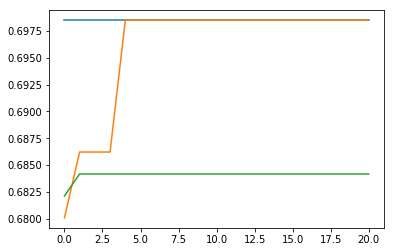

In [28]:
for i in range(3): 
    cs = Cs(x = [protein1,protein2,protein3] ,y = [struct2_1,struct2_2,struct2_3])
    cs.cuckoo()
    print(cs.history)
    plt.plot(range(len(cs.history)), cs.history)

A Jupyter Widget

[0.6923485512442568, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589, 0.6964385307943589]


A Jupyter Widget

[0.6882585716941545, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568, 0.6923485512442568]


A Jupyter Widget

ZeroDivisionError: float division by zero

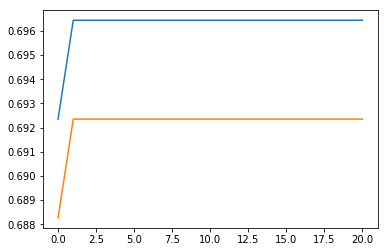

In [21]:
for i in range(3): 
    cs = Cs(x = [protein1,protein2,protein3] ,y = [struct2_1,struct2_2,struct2_3])
    cs.cuckoo()
    print(cs.history)
    plt.plot(range(len(cs.history)), cs.history)

A Jupyter Widget

[0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102]


A Jupyter Widget

[0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102]


A Jupyter Widget

[0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102, 0.6984835205694102]


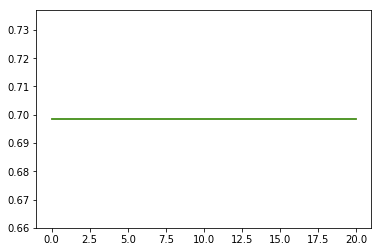

In [22]:
for i in range(3): 
    cs = Cs(x = [protein1,protein2,protein3] ,y = [struct2_1,struct2_2,struct2_3])
    cs.cuckoo()
    print(cs.history)
    plt.plot(range(len(cs.history)), cs.history)